<a href="https://colab.research.google.com/github/ulusberrin/INM706_CW/blob/yasinunsal/sentiment_analysis_lstm_dropout_05_hidden_size_16_batch_size_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
 05180000029.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_112_112.ipynb
 FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb
 FasterRCNN_224_224.ipynb
 FasterRCNN_448_448.ipynb
 faster_rcnn_plots_and_summaries
 fruit-images-for-object-detection
'IMDB Dataset.csv'
 INM702-Task2.ipynb
'INM706_Lab7_Bert_classification (1).ipynb'
 INM706_Lab7_Bert_classification.ipynb
 sentiment_analysis_gru.ipynb
 sentiment_analysis_lstm_dropout_02.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_128.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_16_batch_size_256.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_16_batch_size_64.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_16.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_32.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_64.ipynb
 sentiment_analysis_lstm_dropout_05_hidden_size_8.ipynb
 sentiment_analysis_lstm_dropout_05.ipynb
 sentiment_analysis_lstm.ipynb
 sentim

In [4]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
stopwords = set(stopwords.words("english"))

from sklearn.model_selection import train_test_split
import tensorflow as tf

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv("IMDB Dataset.csv", sep=",")
df.head()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
def remove_html(review):
  review = review.replace("<br /><br />", "")
  return review

def remove_punctuations(review):
  for punctuation in string.punctuation:
    review = review.replace(punctuation, "")
    return review

def remove_digits(review):
  review = "".join(y for y in review if not y.isdigit())
  return review

def remove_nonascii(review):
  review = re.sub(r'[^\x00-\x7f]', r'', review)
  return review

def make_lower(review):
  review = review.lower()
  return review

def remove_stop_words(review):
  review = ' '.join([word for word in review.split() if word not in (stopwords)])
  return review


def clean_review(review):
  review = remove_html(review)
  review = remove_punctuations(review)
  review = remove_digits(review)
  review = remove_nonascii(review)
  review = make_lower(review)
  review = remove_stop_words(review)
  return review


In [7]:
df["clean_review"] = df["review"].progress_apply(clean_review)

df.head()

100%|██████████| 50000/50000 [00:08<00:00, 5820.05it/s]


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production. filming technique...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there's family little boy (jake) thi...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love time money"" visually stu..."


In [8]:
df["sentiment"] = df["sentiment"].replace("positive", 1)
df["sentiment"] = df["sentiment"].replace("negative", 0)


df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production. filming technique...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there's family little boy (jake) thi...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"petter mattei's ""love time money"" visually stu..."


In [9]:

data = df["clean_review"].values.tolist()
target = df["sentiment"].values.tolist()

train_review, temp_review, train_sentiment, temp_sentiment = train_test_split(
                                                                              data,
                                                                              target,
                                                                              random_state=42,
                                                                              test_size=0.3,
                                                                              )
val_review, test_review, val_sentiment, test_sentiment = train_test_split(
                                                                          temp_review,
                                                                          temp_sentiment,
                                                                          random_state=42,
                                                                          test_size = 0.5,
                                                                          )

In [10]:
print(tf.__version__)

#tokenizing process
num_words = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words)
tokenizer.fit_on_texts(data)
tokenizer.word_index

2.15.0


{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'good': 5,
 'the': 6,
 'it': 7,
 'time': 8,
 'even': 9,
 'would': 10,
 'really': 11,
 'see': 12,
 'story': 13,
 'well': 14,
 'much': 15,
 'bad': 16,
 'get': 17,
 'great': 18,
 'also': 19,
 'people': 20,
 'first': 21,
 'made': 22,
 'make': 23,
 'way': 24,
 'movies': 25,
 'could': 26,
 'think': 27,
 'characters': 28,
 'watch': 29,
 'films': 30,
 'two': 31,
 'many': 32,
 'seen': 33,
 'character': 34,
 'never': 35,
 'plot': 36,
 'love': 37,
 'acting': 38,
 'life': 39,
 'best': 40,
 'know': 41,
 'show': 42,
 'little': 43,
 'i': 44,
 'ever': 45,
 'this': 46,
 'better': 47,
 'end': 48,
 'man': 49,
 'scene': 50,
 'still': 51,
 'say': 52,
 'scenes': 53,
 'and': 54,
 'something': 55,
 'go': 56,
 'back': 57,
 'real': 58,
 "i'm": 59,
 'watching': 60,
 'thing': 61,
 'actors': 62,
 'though': 63,
 'years': 64,
 'funny': 65,
 'old': 66,
 'another': 67,
 'work': 68,
 'actually': 69,
 'nothing': 70,
 'makes': 71,
 'look': 72,
 'director': 73,
 'find': 74,

In [11]:
train_review_tokens = tokenizer.texts_to_sequences(train_review)
val_review_tokens = tokenizer.texts_to_sequences(val_review)
test_review_tokens = tokenizer.texts_to_sequences(test_review)

print(train_review[1])
print(train_review_tokens[1])


good ppv, like wrestlemania xx years later, wwe crammed many matches it, matches useless. i'm going go every match card would take forever do.however major highlights included huge pop demolition winning tag team belts haku andre giant, first ever mixed tag match featuring randy savage sensational queen sherri vs dusty rhodes late sapphire first ever clash ultimate warrior hulk hogan.some matches complete waste time. like bolsheviks vs hart foundation seconds long, koko b ware vs rick martel short big bossman vs akeem short.mr perfect vs brutus beefcake ted dibiase vs jake 'the snake' roberts good indeed.overall grade - b
[5, 4, 9009, 64, 216, 5387, 32, 4403, 7, 4403, 3054, 59, 75, 56, 79, 952, 3305, 10, 93, 1332, 440, 94, 575, 3351, 1863, 557, 1491, 1648, 3879, 636, 5369, 1256, 21, 45, 1844, 3879, 952, 1917, 3772, 3655, 7192, 1616, 1502, 8334, 435, 21, 45, 6477, 2033, 3815, 5824, 5921, 1178, 4403, 510, 362, 8, 4, 1502, 4577, 6343, 1543, 100, 397, 1502, 3690, 244, 97, 1502, 244, 349, 3

In [12]:
#padding process

maxlen = 256
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
train_review_pad = pad_sequences(train_review_tokens, maxlen=maxlen)
val_review_pad = pad_sequences(val_review_tokens, maxlen=maxlen)
test_review_pad = pad_sequences(test_review_tokens, maxlen=maxlen)

print(train_review_pad.shape)
print(val_review_pad.shape)
print(test_review_pad.shape)

(35000, 256)
(7500, 256)
(7500, 256)


In [13]:
batch_size = 64

train_set = TensorDataset(torch.from_numpy(train_review_pad), torch.tensor(train_sentiment))
val_set = TensorDataset(torch.from_numpy(val_review_pad), torch.tensor(val_sentiment))
test_set = TensorDataset(torch.from_numpy(test_review_pad), torch.tensor(test_sentiment))

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [14]:
class LSTMModel(nn.Module):
  def __init__(
    self,
    vocab_size,
    output_size,
    hidden_size,
    embedding_size,
    n_layers,
    dropout
    ):

    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    #self.dropout = nn.Dropout(dropout)
    self.dropout1d = nn.Dropout1d(dropout)
    self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
    #self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.long()
    x = self.embedding(x)
    x = self.dropout1d(x)
    out, _ =  self.lstm(x)
    out = out[:, -1, :]
    #out = self.dropout(out)
    out = self.fc(out)
    out = self.sigmoid(out)

    return out

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
vocab_size = num_words
output_size = 1
embedding_size = 256
hidden_size = 16
n_layers = 2
dropout = 0.5

# model initialization
model = LSTMModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

LSTMModel(
  (embedding): Embedding(10000, 256)
  (dropout1d): Dropout1d(p=0.5, inplace=False)
  (lstm): LSTM(256, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
# training config
#lr = 5e-4
#criterion = nn.CrossEntropyLoss()
lr = 0.001
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 10
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

In [18]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

for e in epochloop:

  #train
  model.train()

  train_loss = 0
  train_acc = 0

  for id, (feature, target) in enumerate(train_loader):
      epochloop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')
      feature, target = feature.to(device), target.to(device)
      optim.zero_grad()
      out = model(feature)

      # acc
      predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
      equals = predicted == target
      acc = torch.mean(equals.type(torch.FloatTensor))
      train_acc += acc.item()

      # loss
      loss = criterion(out.squeeze(), target.float())
      train_loss += loss.item()
      loss.backward()

      # clip grad
      nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

      # update optimizer
      optim.step()

      del feature, target, predicted

  history['train_loss'].append(train_loss / len(train_loader))
  history['train_acc'].append(train_acc / len(train_loader))

  #validation
  model.eval()

  val_loss = 0
  val_acc = 0

  with torch.no_grad():
      for id, (feature, target) in enumerate(val_loader):
          epochloop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
          feature, target = feature.to(device), target.to(device)
          out = model(feature)

          # acc
          predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
          equals = predicted == target
          acc = torch.mean(equals.type(torch.FloatTensor))
          val_acc += acc.item()

          # loss
          loss = criterion(out.squeeze(), target.float())
          val_loss += loss.item()

          del feature, target, predicted

      history['val_loss'].append(val_loss / len(val_loader))
      history['val_acc'].append(val_acc / len(val_loader))

  # reset model mode
  model.train()

  # add epoch meta info
  epochloop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

  # print epoch
  if (e+1) % print_every == 0:
      epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
      epochloop.update()


Training:  20%|██        | 2/10 [00:06<00:53,  6.71s/it, Training batch 26/547]

Epoch 1/10 | Train Loss: 0.636 Train Acc: 0.627 | Val Loss: 0.481 Val Acc: 0.793


Training:  40%|████      | 4/10 [00:11<00:21,  3.53s/it, Training batch 25/547]

Epoch 2/10 | Train Loss: 0.493 Train Acc: 0.770 | Val Loss: 0.374 Val Acc: 0.844


Training:  50%|█████     | 5/10 [00:16<00:14,  2.93s/it, Training batch 26/547]

Epoch 3/10 | Train Loss: 0.429 Train Acc: 0.809 | Val Loss: 0.347 Val Acc: 0.858


Training:  70%|███████   | 7/10 [00:21<00:10,  3.40s/it, Training batch 26/547]

Epoch 4/10 | Train Loss: 0.396 Train Acc: 0.826 | Val Loss: 0.322 Val Acc: 0.866


Training:  80%|████████  | 8/10 [00:25<00:05,  2.91s/it, Training batch 25/547]

Epoch 5/10 | Train Loss: 0.372 Train Acc: 0.838 | Val Loss: 0.308 Val Acc: 0.870


Training:  90%|█████████ | 9/10 [00:30<00:03,  3.31s/it, Training batch 26/547]

Epoch 6/10 | Train Loss: 0.360 Train Acc: 0.845 | Val Loss: 0.304 Val Acc: 0.876


Training: 11it [00:34,  3.65s/it, Training batch 25/547]

Epoch 7/10 | Train Loss: 0.347 Train Acc: 0.851 | Val Loss: 0.307 Val Acc: 0.875


Training: 12it [00:39,  3.07s/it, Training batch 26/547]

Epoch 8/10 | Train Loss: 0.340 Train Acc: 0.855 | Val Loss: 0.340 Val Acc: 0.859


Training: 13it [00:43,  3.40s/it, Training batch 26/547]

Epoch 9/10 | Train Loss: 0.333 Train Acc: 0.859 | Val Loss: 0.299 Val Acc: 0.879


Training: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it, Val Loss: 0.301 | Val Acc: 0.872]

Epoch 10/10 | Train Loss: 0.329 Train Acc: 0.860 | Val Loss: 0.301 Val Acc: 0.872


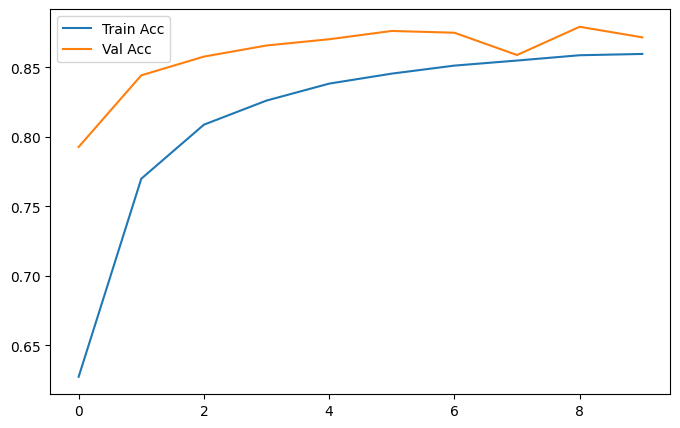

In [19]:
# plot acc
plt.figure(figsize=(8, 5))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

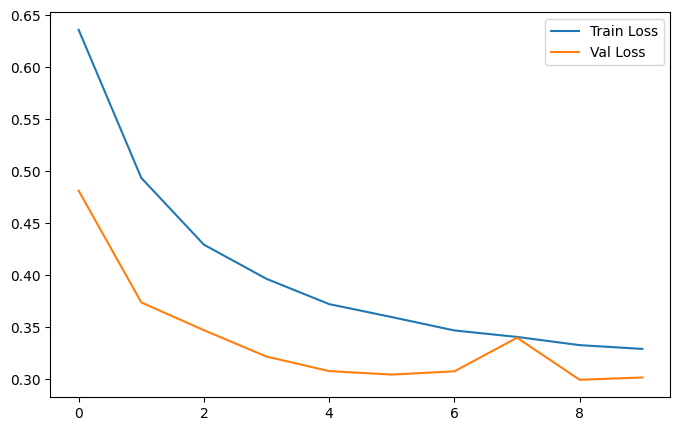

In [20]:
# plot loss
plt.figure(figsize=(8, 5))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [21]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(test_loader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(test_loader):.4f}, Loss: {test_loss/len(test_loader):.4f}')

Inference: 100%|██████████| 118/118 [00:00<00:00, 286.42it/s]

Accuracy: 0.8666, Loss: 0.3224


In [22]:
print(classification_report(all_predicted, all_target))


              precision    recall  f1-score   support

           0       0.79      0.93      0.85      3163
           1       0.94      0.82      0.88      4337

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.88      0.87      0.87      7500



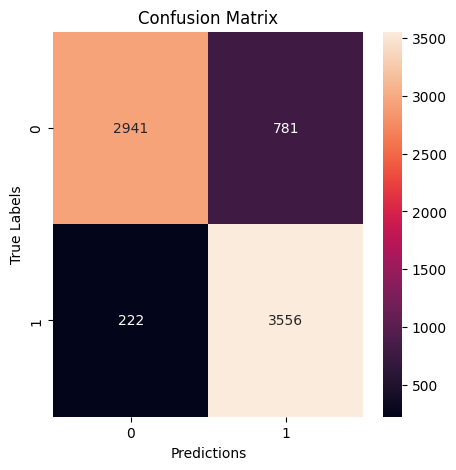

In [23]:
cm = confusion_matrix(all_target, all_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title('Confusion Matrix')
plt.show()

In [24]:
def review_pred(review, model):
  review = [review]
  for i in range(len(review)):
    review[i] = clean_review(review[i])

  review = tokenizer.texts_to_sequences(review)
  review = pad_sequences(review, maxlen=maxlen, dtype="int32")

  sentiment = model(torch.tensor(review).to(device)).to(device)

  pred = sentiment.cpu().detach().numpy()
  print(pred.item())

  if(pred < 0.5):
      print("negative")
  elif (pred >= 0.5):
      print("positive")

review = "this movie is a masterpiece"

review_pred(review, model)

review = "this movie is terrible"

review_pred(review, model)

review = "this movie is not terrible, it's great!"

review_pred(review, model)

review = "this movie is not great, it's terrible!"

review_pred(review, model)


0.5800151824951172
positive
0.32533183693885803
negative
0.44936203956604004
negative
0.4293304979801178
negative
